<a href="https://colab.research.google.com/github/orhansonmeztr/junk/blob/main/BioSimCSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
from platform import python_version
import os 
import sklearn
import json
from sklearn.decomposition import TruncatedSVD, PCA
import joblib
import math
import matplotlib.pyplot as plt
import scann
plt.style.use('ggplot')
from math import log2

2023-04-13 13:31:00.737035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 13:31:01.377581: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-13 13:31:01.450214: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-13 13:31:01.450298: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [ ]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    

def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    #mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        # mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit #, mrr

In [ ]:
dset="biotech"
biotech_abstract_BioSimCSE_norm = np.load('data_biotech_abstract_BioSimCSE_norm.npy')
biotech_title_BioSimCSE_norm = np.load('data_biotech_title_BioSimCSE_norm.npy')

In [ ]:
biotech_abstract_BioSimCSE_norm.shape

(484, 768)

In [ ]:
pca_abstract_BioSimCSE= PCA().fit(biotech_abstract_BioSimCSE_norm)
pca_var_BioSimCSE = np.cumsum(pca_abstract_BioSimCSE.explained_variance_ratio_)

In [ ]:
svd_abstract_BioSimCSE = TruncatedSVD(n_iter= 25, n_components = 768).fit(biotech_abstract_BioSimCSE_norm)
svd_var_BioSimCSE = np.cumsum(svd_abstract_BioSimCSE.explained_variance_ratio_)

In [ ]:
print('PCA 100% :',np.where(np.array(pca_var_BioSimCSE) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var_BioSimCSE) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var_BioSimCSE) >= 0.90)[0][0])

print('SVD 100% :',np.where(np.array(svd_var_BioSimCSE) >= 0.99)[0][0])
print('SVD 95% :',np.where(np.array(svd_var_BioSimCSE) >= 0.95)[0][0])
print('SVD 90% :',np.where(np.array(svd_var_BioSimCSE) >= 0.90)[0][0])

PCA 100% : 149
PCA 95% : 92
PCA 90% : 65
SVD 100% : 150
SVD 95% : 93
SVD 90% : 65


In [ ]:
def pca_reducer(target_dimension, content, title):
    pca_name = '_pca_'+str(target_dimension)
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(content))
    title_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(title))

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save(dset + '_abst_vectors_norm'+pca_name,content_vectors_pca)
    np.save(dset + '_title_vectors_norm'+pca_name,title_vectors_pca)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+pca_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+pca_name, inverse_title)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title):
    svd_name = '_svd_'+str(target_dimension)
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(content))
    title_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(title))

    inverse_content = np.apply_along_axis(vector_normalizer,1,svd_.inverse_transform(content_vectors_svd))
    inverse_title = np.apply_along_axis(vector_normalizer,1,svd_.inverse_transform(title_vectors_svd))

    np.save(dset + '_abst_vectors_norm'+svd_name,content_vectors_svd)
    np.save(dset + '_title_vectors_norm'+svd_name,title_vectors_svd)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+svd_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+svd_name, inverse_title)
    joblib.dump(svd_, svd_name)

In [ ]:
pca_reducer(65, biotech_abstract_BioSimCSE_norm, biotech_title_BioSimCSE_norm)
pca_reducer(93, biotech_abstract_BioSimCSE_norm, biotech_title_BioSimCSE_norm)
pca_reducer(150, biotech_abstract_BioSimCSE_norm, biotech_title_BioSimCSE_norm)
pca_reducer(107, biotech_abstract_BioSimCSE_norm, biotech_title_BioSimCSE_norm)

svd_reducer(65, biotech_abstract_BioSimCSE_norm, biotech_title_BioSimCSE_norm)
svd_reducer(93, biotech_abstract_BioSimCSE_norm, biotech_title_BioSimCSE_norm)
svd_reducer(150, biotech_abstract_BioSimCSE_norm, biotech_title_BioSimCSE_norm)
svd_reducer(107, biotech_abstract_BioSimCSE_norm, biotech_title_BioSimCSE_norm)

In [ ]:
abstract_pca_65 = np.load(dset + '_abst_vectors_norm_pca_65.npy')
title_pca_65 = np.load(dset + '_title_vectors_norm_pca_65.npy')

abstract_pca_93 = np.load(dset + '_abst_vectors_norm_pca_93.npy')
title_pca_93 = np.load(dset + '_title_vectors_norm_pca_93.npy')

abstract_pca_150 = np.load(dset + '_abst_vectors_norm_pca_150.npy')
title_pca_150 = np.load(dset + '_title_vectors_norm_pca_150.npy')

abstract_pca_107 = np.load(dset + '_abst_vectors_norm_pca_107.npy')
title_pca_107 = np.load(dset + '_title_vectors_norm_pca_107.npy')


abstract_svd_65 = np.load(dset + '_abst_vectors_norm_svd_65.npy')
title_svd_65 = np.load(dset + '_title_vectors_norm_svd_65.npy')

abstract_svd_93 = np.load(dset + '_abst_vectors_norm_svd_93.npy')
title_svd_93 = np.load(dset + '_title_vectors_norm_svd_93.npy')

abstract_svd_150 = np.load(dset + '_abst_vectors_norm_svd_150.npy')
title_svd_150 = np.load(dset + '_title_vectors_norm_svd_150.npy')

abstract_svd_107 = np.load(dset + '_abst_vectors_norm_svd_107.npy')
title_svd_107 = np.load(dset + '_title_vectors_norm_svd_107.npy')

In [ ]:
searcher_raw = scann.scann_ops_pybind.builder(biotech_abstract_BioSimCSE_norm, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()


searcher_pca_65 = scann.scann_ops_pybind.builder(abstract_pca_65, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_93 = scann.scann_ops_pybind.builder(abstract_pca_93, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_150 = scann.scann_ops_pybind.builder(abstract_pca_150, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_107 = scann.scann_ops_pybind.builder(abstract_pca_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()


searcher_svd_65 = scann.scann_ops_pybind.builder(abstract_svd_65, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_93 = scann.scann_ops_pybind.builder(abstract_svd_93, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_150 = scann.scann_ops_pybind.builder(abstract_svd_150, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_107 = scann.scann_ops_pybind.builder(abstract_svd_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

2023-04-13 13:32:46.055188: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 484
2023-04-13 13:32:46.102391: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 46.706442ms.
2023-04-13 13:32:47.888817: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 484
2023-04-13 13:32:47.899671: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 10.79862ms.
2023-04-13 13:32:48.066798: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 484
2023-04-13 13:32:48.076474: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 9.621264ms.
2023-04-13 13:32:48.316799: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 484
2023-04-13 13:32:48.331986: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] Parti

In [ ]:
raw_idx = []
reduced_idx_pca_65 = []
reduced_idx_svd_65 = []
reduced_idx_pca_93 = []
reduced_idx_svd_93 = []
reduced_idx_pca_150 = []
reduced_idx_svd_150 = []
reduced_idx_pca_107 = []
reduced_idx_svd_107 = []
for i in range(len(biotech_abstract_BioSimCSE_norm)):
    raw_idx.append(searcher_raw.search(biotech_abstract_BioSimCSE_norm[i])[0])
    reduced_idx_pca_65.append(searcher_pca_65.search(title_pca_65[i])[0])
    reduced_idx_svd_65.append(searcher_svd_65.search(title_svd_65[i])[0])
    reduced_idx_pca_93.append(searcher_pca_93.search(title_pca_93[i])[0])
    reduced_idx_svd_93.append(searcher_svd_93.search(title_svd_93[i])[0])
    reduced_idx_pca_150.append(searcher_pca_150.search(title_pca_150[i])[0])
    reduced_idx_svd_150.append(searcher_svd_150.search(title_svd_150[i])[0])
    reduced_idx_pca_107.append(searcher_pca_107.search(title_pca_107[i])[0])
    reduced_idx_svd_107.append(searcher_svd_107.search(title_svd_107[i])[0])
    

In [ ]:
k = [1,3,5,10,15,20,30]
ap_pca_65, hit_pca_65 = metrics_calculator(raw_idx,reduced_idx_pca_65, k )
ap_svd_65, hit_svd_65 = metrics_calculator(raw_idx,reduced_idx_svd_65, k )

ap_pca_93, hit_pca_93 = metrics_calculator(raw_idx,reduced_idx_pca_93, k )
ap_svd_93, hit_svd_93 = metrics_calculator(raw_idx,reduced_idx_svd_93, k )

ap_pca_150, hit_pca_150 = metrics_calculator(raw_idx,reduced_idx_pca_150, k )
ap_svd_150, hit_svd_150 = metrics_calculator(raw_idx,reduced_idx_svd_150, k )

ap_pca_107, hit_pca_107 = metrics_calculator(raw_idx,reduced_idx_pca_107, k )
ap_svd_107, hit_svd_107 = metrics_calculator(raw_idx,reduced_idx_svd_107, k )

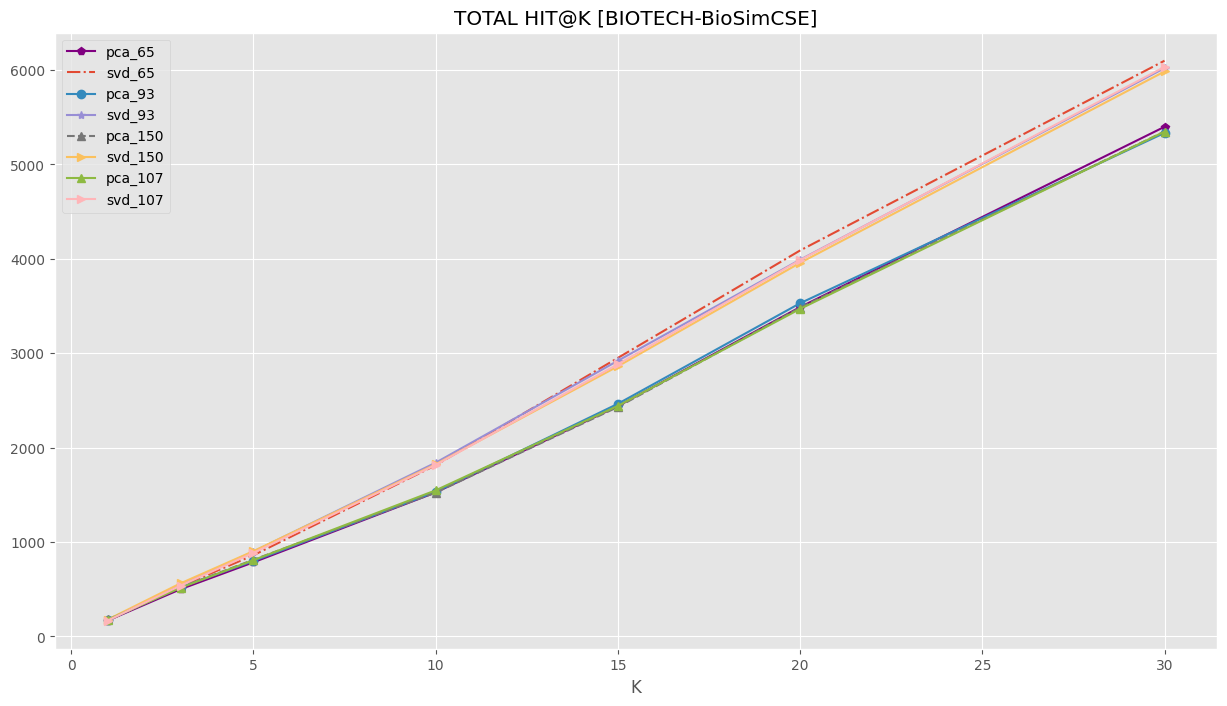

In [ ]:
# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
plt.plot(k,hit_pca_65, '-p', color = 'purple')
plt.plot(k,hit_svd_65, '-.')
plt.plot(k,hit_pca_93, '-o')
plt.plot(k,hit_svd_93, '-*')
plt.plot(k,hit_pca_150, '--^')
plt.plot(k,hit_svd_150, '>-')
plt.plot(k,hit_pca_107, '^-')
plt.plot(k,hit_svd_107, '->')
# plt.scatter(k,hit_pca_107, marker ='s',color= 'green')
# plt.plot(k,hit_svd_107, '--')
# plt.scatter(k,hit_svd_90, marker = 's', color= 'green')

plt.title('TOTAL HIT@K [BIOTECH-BioSimCSE]')
plt.legend(['pca_65','svd_65','pca_93','svd_93','pca_150','svd_150','pca_107','svd_107'])
plt.xlabel('K');

In [ ]:
print(hit_pca_65)
print(hit_pca_93)
print(hit_pca_150)
print(hit_pca_107)
print("-"*50)
print(hit_svd_65)
print(hit_svd_93)
print(hit_svd_150)
print(hit_svd_107)


[169, 501, 786, 1526, 2440, 3489, 5399]
[173, 521, 800, 1531, 2465, 3530, 5334]
[180, 521, 813, 1524, 2431, 3483, 5349]
[177, 516, 809, 1548, 2443, 3470, 5348]
--------------------------------------------------
[167, 531, 861, 1814, 2951, 4089, 6099]
[167, 545, 900, 1841, 2921, 3991, 6021]
[179, 563, 904, 1824, 2862, 3958, 5985]
[169, 539, 886, 1817, 2884, 3987, 6034]
